<a href="https://colab.research.google.com/github/jspark9703/nerf_study/blob/main/examples/vision/ipynb/nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES_COARSE = 64 # Original NeRF는 coarse sampling에 64개 사용
NUM_SAMPLES_FINE = 128  # Original NeRF는 fine sampling에 128개 사용
POS_ENCODE_DIMS_XYZ = 10 # Original NeRF는 xyz에 L=10 사용
POS_ENCODE_DIMS_DIR = 4  # Original NeRF는 view direction에 L=4 사용
EPOCHS = 20 # 필요에 따라 조정


12727482/12727482 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


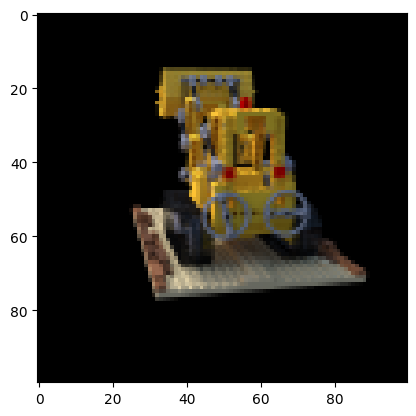

In [2]:
# Download the data if it does not already exist.
url = (
    "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
)
data_path = keras.utils.get_file(origin=url)

data = np.load(data_path)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
# plt.imshow(images[np.random.randint(low=0, high=num_images)])
# plt.show() # 로컬 환경에서 실행 시 주석 해제

In [3]:
for key in data.files:
    print(f"- {key}: shape={data[key].shape}, dtype={data[key].dtype}")

- images: shape=(106, 100, 100, 3), dtype=float32
- poses: shape=(106, 4, 4), dtype=float32
- focal: shape=(), dtype=float64


In [4]:
print("예시 이미지 픽셀 값:", images[0, 0, 0])  # 첫 이미지 왼쪽 위 픽셀
print("예시 카메라 포즈:\n", poses[0])          # 첫 이미지의 카메라 포즈
print("초점 거리 값:", focal)                   # 초점 거리 값


예시 이미지 픽셀 값: [0. 0. 0.]
예시 카메라 포즈:
 [[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
초점 거리 값: 138.88887889922103


In [1]:
def encode_position(x, num_encoding_functions):
    """Encodes the position or direction into its corresponding Fourier feature.

    Args:
        x: The input coordinate or direction (3D).
        num_encoding_functions: The L value for positional encoding.

    Returns:
        Fourier features tensors of the position or direction.
    """
    positions = [x]
    for i in range(num_encoding_functions):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn((2.0**i) * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera (camera-to-world).

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x and y coordinates.
    # Directions are in camera coordinates.
    transformed_i = (i - width * 0.5) / focal
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors in camera coordinates.
    # (x, y, z) in camera frame: (transformed_i, -transformed_j, -1)
    # Negative z because the camera looks along the negative z-axis.
    # Negative y because image y-coordinates usually increase downwards.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Rotate ray directions from camera frame to world frame.
    # The rotation part of the pose matrix is pose[:3, :3].
    # ray_directions = directions @ pose[:3, :3] # This is incorrect for batch operations
    ray_directions = tf.reduce_sum(directions[..., None, :] * pose[:3, :3], axis=-1)


    # Origin of all rays is the camera origin in world coordinates.
    # This is the translation part of the pose matrix: pose[:3, -1].
    ray_origins = tf.broadcast_to(pose[:3, -1], tf.shape(ray_directions))

    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Generates sample points along rays.

    Args:
        ray_origins: Origin of the rays (batch_size, H, W, 3).
        ray_directions: Direction of the rays (batch_size, H, W, 3).
        near: The near bound for sampling.
        far: The far bound for sampling.
        num_samples: Number of samples per ray.
        rand: If True, add random noise to sampling positions.

    Returns:
        Tuple of:
            rays_flat: Sampled points (batch_size * H * W * num_samples, 3).
            directions_flat: Ray directions corresponding to each sample point
                             (batch_size * H * W * num_samples, 3).
            t_vals: The t values for sampling along each ray (batch_size, H, W, num_samples).
    """
    # tf.linspace creates samples from near to far.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Add some randomness to the sampling intervals.
        shape = tf.shape(ray_origins) # (batch_size, H, W, 3)
        # noise shape: (batch_size, H, W, num_samples)
        noise = tf.random.uniform(shape=tf.concat([shape[:-1],[num_samples]], axis=0)) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Expand dimensions of t_vals to multiply with ray_directions.
    # r(t) = o + t*d
    # rays: (batch_size, H, W, num_samples, 3)
    rays = ray_origins[..., None, :] + ray_directions[..., None, :] * t_vals[..., None, None]
    rays_flat = tf.reshape(rays, [-1, 3]) # (batch_size * H * W * num_samples, 3)

    # Each sample point on a ray has the same direction as the ray.
    # directions: (batch_size, H, W, num_samples, 3)
    directions = tf.broadcast_to(ray_directions[..., None, :], tf.shape(rays))
    directions_flat = tf.reshape(directions, [-1, 3]) # (batch_size * H * W * num_samples, 3)

    # Reshape t_vals to match the batch structure for later use.
    t_vals_batched = tf.broadcast_to(t_vals, tf.shape(rays)[ :-1]) # (batch_size, H, W, num_samples)

    return rays_flat, directions_flat, t_vals_batched

  def map_fn_coarse(pose_and_image):
    pose, image = pose_and_image
    ray_origins, ray_directions = get_rays(height=H, width=W, focal=focal, pose=pose)
    # For training, we sample rays randomly from the image to speed up training.
    # Here, for simplicity, we use all rays. Original NeRF selects a subset of rays.
    # To implement random ray sampling:
    #   1. Flatten ray_origins and ray_directions.
    #   2. Randomly select N_rand rays.
    #   3. Reshape corresponding image pixels.
    # For now, we continue with all rays and will apply batching later.

    rays_flat, dirs_flat, t_vals = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES_COARSE,
        rand=True, # Random sampling during training
    )
    # Return structure expected by NeRF model's train_step
    return (image, (ray_origins, ray_directions, t_vals))

# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images.astype(np.float32)/255.0) # Normalize images
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses.astype(np.float32))
train_dataset_raw = tf.data.Dataset.zip((train_pose_ds, train_img_ds))

# Map poses to rays and t_vals for coarse sampling
train_ds = (
    train_dataset_raw.map(map_fn_coarse, num_parallel_calls=AUTO)
    .shuffle(BATCH_SIZE * 10) # Shuffle before batching
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)


# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images.astype(np.float32)/255.0) # Normalize images
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses.astype(np.float32))
val_dataset_raw = tf.data.Dataset.zip((val_pose_ds, val_img_ds))

val_ds = (
    val_dataset_raw.map(map_fn_coarse, num_parallel_calls=AUTO) # Use same map_fn, rand=True is ok for val coarse
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)


In [ ]:
for images_batch, (ray_origins, ray_directions, t_vals_batch) in train_ds.take(1):
    print("✅ 이미지 배치")
    print("images_batch.shape:", images_batch.shape)

    print("\n✅ 광선 원점 (ray origins)")
    print("ray_origins.shape:", ray_origins.shape)

    print("\n✅ 광선 방향 (ray directions)")
    print("ray_directions.shape:", ray_directions.shape)

    print("\n✅ 각 샘플 포인트의 깊이 값 (t_vals)")
    print("t_vals_batch.shape:", t_vals_batch.shape)


✅ 이미지 배치
images_batch.shape: (5, 100, 100, 3)

✅ 광선 원점 (ray origins)
ray_origins.shape: (5, 100, 100, 3)

✅ 광선 방향 (ray directions)
ray_directions.shape: (5, 100, 100, 3)

✅ 각 샘플 포인트의 깊이 값 (t_vals)
t_vals_batch.shape: (5, 100, 100, 32)


## NeRF model

The model is a multi-layer perceptron (MLP), with ReLU as its non-linearity.

An excerpt from the paper:

*"We encourage the representation to be multiview-consistent by
restricting the network to predict the volume density sigma as a
function of only the location `x`, while allowing the RGB color `c` to be
predicted as a function of both location and viewing direction. To
accomplish this, the MLP first processes the input 3D coordinate `x`
with 8 fully-connected layers (using ReLU activations and 256 channels
per layer), and outputs sigma and a 256-dimensional feature vector.
This feature vector is then concatenated with the camera ray's viewing
direction and passed to one additional fully-connected layer (using a
ReLU activation and 128 channels) that output the view-dependent RGB
color."*

Here we have gone for a minimal implementation and have used 64
Dense units instead of 256 as mentioned in the paper.

In [ ]:
def get_nerf_model(num_layers=8, dense_units=256, skip_layer=4,
                   pos_encode_dims_xyz=POS_ENCODE_DIMS_XYZ,
                   pos_encode_dims_dir=POS_ENCODE_DIMS_DIR):
    """Defines the NeRF MLP model.

    Args:
        num_layers: Number of dense layers for position.
        dense_units: Number of units in each dense layer.
        skip_layer: Layer index for skip connection.
        pos_encode_dims_xyz: L for position encoding.
        pos_encode_dims_dir: L for direction encoding.

    Returns:
        A Keras model for NeRF.
    """
    # Input for encoded position (x,y,z)
    # Each of x, y, z is encoded to 2*L + 1 dimensions. So total (2*L_xyz + 1) * 3
    # However, the original paper's positional encoding also includes the raw coordinate.
    # So, for each coordinate: x, sin(x), cos(x), sin(2x), cos(2x), ..., sin(2^(L-1)x), cos(2^(L-1)x)
    # This is 1 (raw) + 2*L dimensions.
    # For 3 coordinates (x,y,z), it's 3 * (1 + 2*L_xyz)
    input_xyz_encoded_shape = (1 + 2 * pos_encode_dims_xyz) * 3
    input_dir_encoded_shape = (1 + 2 * pos_encode_dims_dir) * 3

    input_xyz = keras.Input(shape=(input_xyz_encoded_shape), name="encoded_xyz")
    input_dir = keras.Input(shape=(input_dir_encoded_shape), name="encoded_dir")

    # Position encoding pathway
    x = input_xyz
    for i in range(num_layers):
        x = layers.Dense(dense_units, activation="relu")(x)
        if i == skip_layer:
            x = layers.concatenate([x, input_xyz]) # Skip connection

    # Sigma (Density) head
    # The density sigma is predicted from the features of the position only.
    sigma = layers.Dense(1, activation=None, name="sigma")(x) # No activation, will be ReLU'd later

    # Feature vector for RGB prediction
    # This feature vector is then concatenated with the view direction.
    feature_vector = layers.Dense(dense_units, activation=None)(x) # No activation here as per diagram

    # Concatenate feature vector with encoded direction
    concat_feature_dir = layers.concatenate([feature_vector, input_dir])
    rgb_intermediate = layers.Dense(dense_units // 2, activation="relu")(concat_feature_dir)
    rgb = layers.Dense(3, activation="sigmoid", name="rgb")(rgb_intermediate) # Sigmoid for [0,1] RGB

    # Final output: concatenate RGB and sigma
    output = layers.concatenate([rgb, sigma], axis=-1) # Shape: (batch, 4)

    return keras.Model(inputs=[input_xyz, input_dir], outputs=output, name="NeRF_MLP")


def volumetric_rendering(raw_output, t_vals, batch_size, H_dim, W_dim, num_samples_dim):
    """Performs volumetric rendering on the raw MLP outputs.

    Args:
        raw_output: Raw output from the MLP (batch_size * H * W * num_samples, 4).
                    Contains [rgb, sigma].
        t_vals: The t values for sampling along each ray (batch_size, H, W, num_samples).
        batch_size: The batch size.
        H_dim: Height of the image.
        W_dim: Width of the image.
        num_samples_dim: Number of samples along each ray.

    Returns:
        Tuple of:
            rgb_map: Rendered RGB image (batch_size, H, W, 3).
            depth_map: Rendered depth map (batch_size, H, W).
            weights: Volumetric rendering weights (batch_size, H, W, num_samples).
    """
    # Reshape raw output to (batch_size, H, W, num_samples, 4)
    raw_output_reshaped = tf.reshape(raw_output, (batch_size, H_dim, W_dim, num_samples_dim, 4))

    # Extract RGB and sigma
    rgb = tf.sigmoid(raw_output_reshaped[..., :3]) # Apply sigmoid to raw RGB logits if not already applied
    sigma_a = tf.nn.relu(raw_output_reshaped[..., 3]) # Apply ReLU to raw sigma

    # Calculate delta: distance between adjacent samples
    # t_vals shape: (batch_size, H, W, num_samples)
    delta = t_vals[..., 1:] - t_vals[..., :-1] # (batch_size, H, W, num_samples-1)

    # Add a large value for the last interval (delta for the last sample)
    # This approximates infinity, meaning the ray travels indefinitely after the last sample.
    delta = tf.concat(
        [delta, tf.broadcast_to([1e10], shape=(batch_size, H_dim, W_dim, 1))], axis=-1
    ) # (batch_size, H, W, num_samples)

    # Calculate alpha: opacity for each sample
    # alpha = 1 - exp(-sigma_a * delta)
    alpha = 1.0 - tf.exp(-sigma_a * delta) # (batch_size, H, W, num_samples)

    # Calculate transmittance T_i: probability that the ray travels from near plane to sample i
    # without hitting anything.
    # T_i = product_{j=1 to i-1} (1 - alpha_j)
    # tf.math.cumprod computes cumulative product. exclusive=True means T_1 = 1.
    transmittance = tf.math.cumprod(1.0 - alpha + 1e-10, axis=-1, exclusive=True) # Add epsilon for stability

    # Calculate weights for each sample: w_i = T_i * alpha_i
    weights = alpha * transmittance # (batch_size, H, W, num_samples)

    # Calculate final RGB color for each ray (weighted sum of sample colors)
    # rgb_map = sum_{i=1 to N} w_i * c_i
    rgb_map = tf.reduce_sum(weights[..., None] * rgb, axis=-2) # (batch_size, H, W, 3)

    # Calculate depth map (expected depth along each ray)
    # depth_map = sum_{i=1 to N} w_i * t_i
    depth_map = tf.reduce_sum(weights * t_vals, axis=-1) # (batch_size, H, W)

    return rgb_map, depth_map, weights


def sample_pdf(bins, weights, num_samples_fine, det=False):
    """Hierarchical sampling: sample points from a PDF defined by coarse weights.

    Args:
        bins: Midpoints of the coarse sampling intervals (batch_size, H, W, num_coarse_samples-1).
        weights: Weights from the coarse rendering (batch_size, H, W, num_coarse_samples).
                 We use weights[:, :, :, 1:-1] corresponding to the bins.
        num_samples_fine: Number of fine samples per ray.
        det: If True, use deterministic sampling (linspace). Otherwise, random.

    Returns:
        Fine samples t_vals (batch_size, H, W, num_samples_fine).
    """
    # Add a small epsilon to weights to prevent NaNs when all weights are zero.
    weights = weights + 1e-5
    # Normalize weights to get a PDF.
    # pdf shape: (batch_size, H, W, num_coarse_samples-2)
    pdf = weights / tf.reduce_sum(weights, axis=-1, keepdims=True)

    # Calculate CDF (Cumulative Distribution Function).
    # cdf shape: (batch_size, H, W, num_coarse_samples-2)
    cdf = tf.cumsum(pdf, axis=-1)
    # Prepend zeros to the CDF to handle edge cases in searchsorted.
    # cdf shape: (batch_size, H, W, num_coarse_samples-1)
    cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], axis=-1)


    # Generate uniform samples for inverse transform sampling.
    batch_dims = tf.shape(cdf)[:-1] # (batch_size, H, W)
    if det: # Deterministic sampling
        u = tf.linspace(0.0, 1.0, num_samples_fine)
        u = tf.broadcast_to(u, tf.concat([batch_dims, [num_samples_fine]], axis=0))
    else: # Random sampling
        u = tf.random.uniform(shape=tf.concat([batch_dims, [num_samples_fine]], axis=0))

    # `tf.searchsorted` finds the indices where elements of `u` would be inserted
    # into `cdf` to maintain order. This is the core of inverse transform sampling.
    # `inds` will have shape (batch_size, H, W, num_samples_fine)
    inds = tf.searchsorted(cdf, u, side='right')

    # Correct indices to be within bounds of `bins`.
    below = tf.maximum(0, inds - 1)
    above = tf.minimum(tf.shape(cdf)[-1] - 1, inds)
    inds_g = tf.stack([below, above], axis=-1) # (batch_size, H, W, num_samples_fine, 2)

    # Gather corresponding CDF values and bin values using the sampled indices.
    # cdf_g and bins_g will have shape (batch_size, H, W, num_samples_fine, 2)
    cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=tf.rank(cdf)-1) # batch_dims = 3 for (B,H,W,N_cdf)
    bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=tf.rank(bins)-1) # batch_dims = 3 for (B,H,W,N_bins)

    # Perform linear interpolation to get the fine sample t_vals.
    denom = cdf_g[..., 1] - cdf_g[..., 0]
    # Avoid division by zero if cdf_g[..., 1] == cdf_g[..., 0]
    denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples # (batch_size, H, W, num_samples_fine)


def render_nerf_hierarchical(
    coarse_model, fine_model, ray_origins, ray_directions, t_vals_coarse,
    num_samples_fine, rand_fine_sampling=True):
    """
    Renders rays using a hierarchical sampling approach (coarse and fine models).

    Args:
        coarse_model: The coarse NeRF Keras model.
        fine_model: The fine NeRF Keras model.
        ray_origins: Ray origins (batch_size, H, W, 3).
        ray_directions: Ray directions (batch_size, H, W, 3).
        t_vals_coarse: Coarse sampling t_vals (batch_size, H, W, num_samples_coarse).
        num_samples_fine: Number of samples for the fine model.
        rand_fine_sampling: Whether to use random sampling for fine stage during training.

    Returns:
        A dictionary containing:
            'rgb_coarse': Rendered RGB from coarse model.
            'depth_coarse': Rendered depth from coarse model.
            'rgb_fine': Rendered RGB from fine model.
            'depth_fine': Rendered depth from fine model.
    """
    batch_size = tf.shape(ray_origins)[0]
    h_dim = tf.shape(ray_origins)[1]
    w_dim = tf.shape(ray_origins)[2]
    num_samples_coarse = tf.shape(t_vals_coarse)[-1]

    # 1. COARSE MODEL RENDERING
    # Generate points and directions for coarse model input
    # pts_coarse: (batch_size, H, W, num_samples_coarse, 3)
    pts_coarse = ray_origins[..., None, :] + ray_directions[..., None, :] * t_vals_coarse[..., None]
    dirs_coarse = tf.broadcast_to(ray_directions[..., None, :], tf.shape(pts_coarse))

    pts_coarse_flat = tf.reshape(pts_coarse, [-1, 3])
    dirs_coarse_flat = tf.reshape(dirs_coarse, [-1, 3])

    # Encode inputs
    encoded_pts_coarse = encode_position(pts_coarse_flat, POS_ENCODE_DIMS_XYZ)
    encoded_dirs_coarse = encode_position(dirs_coarse_flat, POS_ENCODE_DIMS_DIR)

    # Predict with coarse model
    raw_output_coarse = coarse_model([encoded_pts_coarse, encoded_dirs_coarse])

    # Volumetric rendering for coarse model
    rgb_map_coarse, depth_map_coarse, weights_coarse = volumetric_rendering(
        raw_output_coarse, t_vals_coarse, batch_size, h_dim, w_dim, num_samples_coarse
    )

    # 2. HIERARCHICAL SAMPLING FOR FINE MODEL
    # Get midpoints of coarse sample intervals for PDF sampling
    # t_vals_coarse shape: (B, H, W, Nc)
    # mid_t_vals shape: (B, H, W, Nc-1)
    mid_t_vals_coarse = 0.5 * (t_vals_coarse[..., :-1] + t_vals_coarse[..., 1:])

    # Sample fine t_vals based on coarse weights
    # weights_coarse shape: (B, H, W, Nc)
    # We use weights[:, :, :, 1:-1] for the PDF, corresponding to mid_t_vals_coarse
    t_vals_fine_sampled = sample_pdf(
        mid_t_vals_coarse,
        weights_coarse[..., 1:-1], # Use weights corresponding to intervals
        num_samples_fine,
        det=not rand_fine_sampling # Use deterministic for testing, random for training
    )
    # t_vals_fine_sampled shape: (B, H, W, Nf)

    # Combine coarse and fine t_vals and sort them
    # t_vals_all shape: (B, H, W, Nc + Nf)
    t_vals_all = tf.sort(tf.concat([t_vals_coarse, t_vals_fine_sampled], axis=-1), axis=-1)
    num_samples_all = num_samples_coarse + num_samples_fine

    # 3. FINE MODEL RENDERING
    # Generate points and directions for fine model input using all t_vals
    # pts_fine: (batch_size, H, W, num_samples_all, 3)
    pts_fine = ray_origins[..., None, :] + ray_directions[..., None, :] * t_vals_all[..., None]
    dirs_fine = tf.broadcast_to(ray_directions[..., None, :], tf.shape(pts_fine))

    pts_fine_flat = tf.reshape(pts_fine, [-1, 3])
    dirs_fine_flat = tf.reshape(dirs_fine, [-1, 3])

    # Encode inputs
    encoded_pts_fine = encode_position(pts_fine_flat, POS_ENCODE_DIMS_XYZ)
    encoded_dirs_fine = encode_position(dirs_fine_flat, POS_ENCODE_DIMS_DIR)

    # Predict with fine model
    raw_output_fine = fine_model([encoded_pts_fine, encoded_dirs_fine])

    # Volumetric rendering for fine model
    rgb_map_fine, depth_map_fine, _ = volumetric_rendering(
        raw_output_fine, t_vals_all, batch_size, h_dim, w_dim, num_samples_all
    )

    return {
        "rgb_coarse": rgb_map_coarse,
        "depth_coarse": depth_map_coarse,
        "rgb_fine": rgb_map_fine,
        "depth_fine": depth_map_fine,
    }


## Training

The training step is implemented as part of a custom `keras.Model` subclass
so that we can make use of the `model.fit` functionality.

In [ ]:
class NeRFModel(keras.Model):
    def __init__(self, coarse_mlp, fine_mlp, num_samples_fine):
        super().__init__()
        self.coarse_mlp = coarse_mlp
        self.fine_mlp = fine_mlp
        self.num_samples_fine = num_samples_fine
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_tracker = keras.metrics.Mean(name="psnr") # PSNR on fine model output

    def compile(self, optimizer_coarse, optimizer_fine, loss_fn):
        super().compile()
        # Original NeRF uses the same optimizer for both, but we can have separate if needed
        self.optimizer_coarse = optimizer_coarse
        self.optimizer_fine = optimizer_fine
        self.loss_fn = loss_fn


    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_tracker]

    def train_step(self, inputs):
        # `inputs` from tf.data pipeline: (images_batch, (rays_o_batch, rays_d_batch, t_vals_coarse_batch))
        target_images, (rays_o, rays_d, t_vals_coarse) = inputs

        with tf.GradientTape() as tape:
            # Render with hierarchical sampling
            renderings = render_nerf_hierarchical(
                self.coarse_mlp, self.fine_mlp, rays_o, rays_d, t_vals_coarse,
                self.num_samples_fine, rand_fine_sampling=True # Random fine sampling for training
            )
            rgb_coarse = renderings["rgb_coarse"]
            rgb_fine = renderings["rgb_fine"]

            # Compute losses
            loss_coarse = self.loss_fn(target_images, rgb_coarse)
            loss_fine = self.loss_fn(target_images, rgb_fine)
            total_loss = loss_coarse + loss_fine # Sum of coarse and fine losses

        # Compute gradients and apply to both models
        trainable_vars = self.coarse_mlp.trainable_variables + self.fine_mlp.trainable_variables
        grads = tape.gradient(total_loss, trainable_vars)
        # Assuming a single optimizer for both for simplicity, or adapt if using two
        self.optimizer.apply_gradients(zip(grads, trainable_vars))


        # Update metrics
        self.loss_tracker.update_state(total_loss)
        psnr = tf.image.psnr(target_images, rgb_fine, max_val=1.0) # PSNR based on fine model
        self.psnr_tracker.update_state(psnr)

        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_tracker.result()}

    def test_step(self, inputs):
        target_images, (rays_o, rays_d, t_vals_coarse) = inputs

        renderings = render_nerf_hierarchical(
            self.coarse_mlp, self.fine_mlp, rays_o, rays_d, t_vals_coarse,
            self.num_samples_fine, rand_fine_sampling=False # Deterministic fine sampling for testing
        )
        rgb_coarse = renderings["rgb_coarse"]
        rgb_fine = renderings["rgb_fine"]

        loss_coarse = self.loss_fn(target_images, rgb_coarse)
        loss_fine = self.loss_fn(target_images, rgb_fine)
        total_loss = loss_coarse + loss_fine

        self.loss_tracker.update_state(total_loss)
        psnr = tf.image.psnr(target_images, rgb_fine, max_val=1.0)
        self.psnr_tracker.update_state(psnr)

        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_tracker.result()}

    # Add a predict_step or call method for inference if needed outside of fit/evaluate
    def call(self, inputs, training=False):
        # `inputs`: (rays_o, rays_d, t_vals_coarse)
        rays_o, rays_d, t_vals_coarse = inputs
        renderings = render_nerf_hierarchical(
            self.coarse_mlp, self.fine_mlp, rays_o, rays_d, t_vals_coarse,
            self.num_samples_fine, rand_fine_sampling=training
        )
        # Return fine model output for inference by default
        return renderings["rgb_fine"], renderings["depth_fine"]


# Instantiate models
coarse_nerf_mlp = get_nerf_model(
    num_layers=8, dense_units=256, skip_layer=4,
    pos_encode_dims_xyz=POS_ENCODE_DIMS_XYZ,
    pos_encode_dims_dir=POS_ENCODE_DIMS_DIR
)
fine_nerf_mlp = get_nerf_model(
    num_layers=8, dense_units=256, skip_layer=4,
    pos_encode_dims_xyz=POS_ENCODE_DIMS_XYZ,
    pos_encode_dims_dir=POS_ENCODE_DIMS_DIR
)

# Combined NeRF model
nerf_system = NeRFModel(coarse_nerf_mlp, fine_nerf_mlp, NUM_SAMPLES_FINE)

# Compile the model
# Original NeRF uses Adam optimizer with lr 5e-4, decaying
learning_rate = 5e-4 # Can add learning rate schedule later
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = keras.losses.MeanSquaredError()

# If using separate optimizers:
# optimizer_coarse = keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer_fine = keras.optimizers.Adam(learning_rate=learning_rate)
# nerf_system.compile(optimizer_coarse=optimizer_coarse, optimizer_fine=optimizer_fine, loss_fn=loss_function)

nerf_system.compile(optimizer=optimizer, loss_fn=loss_function) # Use this if NeRFModel's train_step uses self.optimizer


loss_list_train = [] # For plotting training loss

# Get a single batch from validation set for visualization during training
val_iter = iter(val_ds)
val_batch_for_viz = next(val_iter)

class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_list_train.append(logs["loss"])

        # Use the NeRFModel's call method for inference
        target_images_viz, (rays_o_viz, rays_d_viz, t_vals_coarse_viz) = val_batch_for_viz

        # Reshape t_vals_coarse_viz if it's flattened by map_fn before batching
        # Ensure t_vals_coarse_viz has shape (BATCH_SIZE, H, W, NUM_SAMPLES_COARSE)
        # The map_fn currently returns (ray_origins, ray_directions, t_vals)
        # where t_vals is already (B, H, W, N_samples_coarse) from render_flat_rays
        # So, no explicit reshape might be needed here if map_fn and batching are correct.

        predicted_rgb_fine, predicted_depth_fine = self.model(
            (rays_o_viz, rays_d_viz, t_vals_coarse_viz), training=False
        )

        # Plot the rgb, depth and the loss plot.
        # Display for the first image in the validation batch
        num_images_to_show = min(BATCH_SIZE, 3) # Show up to 3 images
        fig, axes = plt.subplots(nrows=num_images_to_show, ncols=4, figsize=(20, 5 * num_images_to_show))
        if num_images_to_show == 1: # if axes is not an array of arrays
            axes = np.array([axes])


        for i in range(num_images_to_show):
            ax_row = axes[i]
            ax_row[0].imshow(keras.utils.array_to_img(target_images_viz[i]))
            ax_row[0].set_title(f"Target Image {i}")

            ax_row[1].imshow(keras.utils.array_to_img(predicted_rgb_fine[i]))
            ax_row[1].set_title(f"Predicted Fine RGB {i} (Epoch: {epoch:03d})")

            ax_row[2].imshow(keras.utils.array_to_img(predicted_depth_fine[i, ..., None]))
            ax_row[2].set_title(f"Predicted Fine Depth {i} (Epoch: {epoch:03d})")

        # Plot loss on the last subplot of the first row (or a dedicated one)
        axes[0,3].plot(loss_list_train)
        axes[0,3].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        axes[0,3].set_title(f"Training Loss (Epoch: {epoch:03d})")
        for j in range(1, num_images_to_show): # Hide extra loss plots
             axes[j,3].axis('off')


        if not os.path.exists("images_original_nerf"):
            os.makedirs("images_original_nerf")
        fig.savefig(f"images_original_nerf/{epoch:03d}.png")
        # plt.show() # 로컬에서 실행 시 주석 해제
        plt.close(fig)


# Create a directory to save the images during training.
if not os.path.exists("images_original_nerf"):
    os.makedirs("images_original_nerf")

print("Starting training...")
nerf_system.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()]
)
print("Training finished.")


def create_gif(path_to_images_pattern, name_gif):
    filenames = glob.glob(path_to_images_pattern)
    filenames = sorted(filenames)
    generated_images = []
    for filename in tqdm(filenames):
        try:
            generated_images.append(imageio.imread(filename))
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue # Skip problematic files

    if not generated_images:
        print(f"No images found for pattern {path_to_images_pattern} or all were problematic.")
        return

    kargs = {"duration": 0.25, "loop": 0} # Loop indefinitely
    try:
        imageio.mimsave(name_gif, generated_images, "GIF", **kargs)
        print(f"GIF saved as {name_gif}")
    except Exception as e:
        print(f"Error creating GIF: {e}")


create_gif("images_original_nerf/*.png", "training_original_nerf.gif")

ValueError: Cannot convert '99' to a shape.

In [ ]:
# --- Inference and Video Generation (Similar to provided code, adapted for the new model) ---

# Get a batch from the test set for inference visualization
test_imgs_viz, (test_rays_o_viz, test_rays_d_viz, test_t_vals_coarse_viz) = next(iter(val_ds)) # Using val_ds as test here

# Infer with the trained model
recons_images_fine, depth_maps_fine = nerf_system(
    (test_rays_o_viz, test_rays_d_viz, test_t_vals_coarse_viz), training=False
)

# Create subplots for visualization
num_viz_samples = min(BATCH_SIZE, 5)
fig, axes = plt.subplots(nrows=num_viz_samples, ncols=3, figsize=(10, 4 * num_viz_samples))
if num_viz_samples == 1:
    axes = np.array([axes])


for i in range(num_viz_samples):
    ax_row = axes[i]
    ax_row[0].imshow(keras.utils.array_to_img(test_imgs_viz[i]))
    ax_row[0].set_title("Original")

    ax_row[1].imshow(keras.utils.array_to_img(recons_images_fine[i]))
    ax_row[1].set_title("Reconstructed (Fine)")

    ax_row[2].imshow(keras.utils.array_to_img(depth_maps_fine[i, ..., None]), cmap="inferno")
    ax_row[2].set_title("Depth Map (Fine)")
    ax_row[2].axes.get_xaxis().set_visible(False)
    ax_row[2].axes.get_yaxis().set_visible(False)


plt.tight_layout()
# plt.show() # 로컬에서 실행 시 주석 해제
plt.savefig("inference_visualization_original_nerf.png")
print("Inference visualization saved as inference_visualization_original_nerf.png")
plt.close(fig)

# Functions for novel view synthesis video (can be adapted from your original code)
def get_translation_t(t):
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)

def get_rotation_phi(phi): # around X-axis
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)

def get_rotation_theta(theta): # around Y-axis
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)

def pose_spherical(theta, phi, radius):
    c2w = get_translation_t(radius)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    # This is a common transformation to align camera axes with standard conventions
    c2w = tf.convert_to_tensor(np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]), dtype=tf.float32) @ c2w
    return c2w


print("Generating novel view synthesis video...")
rgb_frames = []
num_video_frames = 60 # Fewer frames for quicker generation for testing
video_batch_size = BATCH_SIZE # Process in batches if memory is an issue

for i in tqdm(range(0, num_video_frames, video_batch_size)):
    current_batch_size = min(video_batch_size, num_video_frames - i)
    batch_rays_o = []
    batch_rays_d = []
    batch_t_vals_coarse = []

    for j in range(current_batch_size):
        theta = (i + j) * (360.0 / num_video_frames)
        c2w = pose_spherical(theta, -30.0, 4.0) # Example view parameters

        ray_origins_single, ray_directions_single = get_rays(H, W, focal, c2w)
        # Expand dims to simulate batch for render_flat_rays if it expects it,
        # or adjust render_flat_rays. Here, get_rays already returns unbatched HxWx3.
        # We will batch them *after* this loop.

        # Coarse t_vals for this single pose (needs to be shaped for the model later)
        # Here, we ensure t_vals are generated for a single "image" view.
        # The render_flat_rays will produce t_vals of shape (H, W, N_samples)
        # We need to add a batch dim for the model.
        _, _, t_vals_coarse_single = render_flat_rays(
            ray_origins_single[None,...], ray_directions_single[None,...], # Add batch dim for this call
            near=2.0, far=6.0,
            num_samples=NUM_SAMPLES_COARSE,
            rand=False # No random sampling for video generation
        )
        # t_vals_coarse_single is (1, H, W, N_samples), remove batch for list append
        batch_rays_o.append(ray_origins_single)
        batch_rays_d.append(ray_directions_single)
        batch_t_vals_coarse.append(tf.squeeze(t_vals_coarse_single, axis=0))


    # Stack to create a batch
    rays_o_batch_video = tf.stack(batch_rays_o, axis=0) # (current_batch_size, H, W, 3)
    rays_d_batch_video = tf.stack(batch_rays_d, axis=0) # (current_batch_size, H, W, 3)
    t_vals_coarse_batch_video = tf.stack(batch_t_vals_coarse, axis=0) # (current_batch_size, H, W, N_coarse)

    # Infer with the model
    rgb_fine_video_batch, _ = nerf_system(
        (rays_o_batch_video, rays_d_batch_video, t_vals_coarse_batch_video), training=False
    )

    # Process and store frames
    for k in range(current_batch_size):
        img_np = np.clip(255 * rgb_fine_video_batch[k].numpy(), 0.0, 255.0).astype(np.uint8)
        rgb_frames.append(img_np)


if rgb_frames:
    rgb_video_path = "rgb_video_original_nerf.mp4"
    imageio.mimwrite(rgb_video_path, rgb_frames, fps=30, quality=8, macro_block_size=1) # quality 1-10
    print(f"Novel view video saved as {rgb_video_path}")
else:
    print("No frames generated for the video.")